In [1]:
import pandas as pd
import numpy as np
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

C:\Users\maclu\anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


## Loading Datset

In [2]:
df = pd.read_csv("data job posts.csv")
df=df[df['Title'].isnull()==False]
df.reset_index(inplace=True)

df.head(5)

,index,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18973 entries, 0 to 18972
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   index             18973 non-null  int64 
 1   jobpost           18973 non-null  object
 2   date              18973 non-null  object
 3   Title             18973 non-null  object
 4   Company           18973 non-null  object
 5   AnnouncementCode  1206 non-null   object
 6   Term              7671 non-null   object
 7   Eligibility       4929 non-null   object
 8   Audience          640 non-null    object
 9   StartDate         9672 non-null   object
 10  Duration          10788 non-null  object
 11  Location          18948 non-null  object
 12  JobDescription    15090 non-null  object
 13  JobRequirment     16459 non-null  object
 14  RequiredQual      18496 non-null  object
 15  Salary            9614 non-null   object
 16  ApplicationP      18920 non-null  object
 17  OpeningDate 

In [4]:
#Finding the job nature and store in variable x
X=df['Title']

In [5]:
len(X)

18973

### Creating the Corpus

In [6]:
import re
corpus = []
for i in range(0, len(X)):
    review = re.sub(r'\W', ' ', str(X[i]))
    review = re.sub(r'^br$', ' ', review)
    review = re.sub(r'\s+[a-z]\s+', ' ',review)
    review = re.sub(r'^[a-z]\s+', ' ', review)
    review = re.sub(r'\s+', ' ', review)
    corpus.append(review)  

#### Removing all punctuations from Title

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  

data_words = list(sent_to_words(corpus))

data_words[0]

['chief', 'financial', 'officer']

#### Define Stopwords, bigram model and lemmatization for title data

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=100) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [10]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','na','Senior','new','branch','Junior','unit','department','Specialist','the','unit'])

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['chief', 'financial', 'officer']]


In [14]:
data_lemmatized[0:10]

[['chief', 'financial', 'officer'],
 ['community', 'connection', 'intern', 'pay', 'internship'],
 ['country', 'coordinator'],
 ['specialist'],
 ['software', 'developer'],
 [],
 ['chief', 'accountant', 'finance', 'assistant'],
 ['pay', 'part', 'full_time', 'programmatic', 'intern'],
 ['assistant', 'manage', 'director'],
 ['program', 'assistant']]

In [15]:
# few null value is also coming so we are going to remove null from list
list2 = [x for x in data_lemmatized if x != []]

In [16]:
for i in range(len(list2)):
    list2[i] = ' '.join(list2[i])

In [17]:
list2[0:5]

['chief financial officer',
 'community connection intern pay internship',
 'country coordinator',
 'specialist',
 'software developer']

#### Now we will select 1000 title for word cloud

In [18]:
titlecount = {}
for data in list2:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in titlecount.keys():
            titlecount[word] = 1
        else:
            titlecount[word] += 1

In [19]:
len(titlecount)

1832

In [22]:
import heapq
freq_words = heapq.nlargest(1000,titlecount,key=titlecount.get)

In [23]:
%%capture
text = " ".join(freq_words)

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

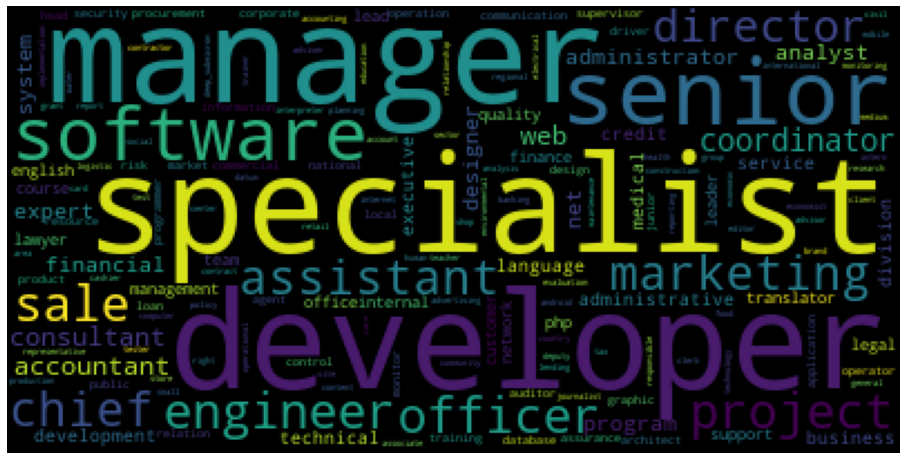

In [25]:
wordcloud = WordCloud(stopwords=[],max_font_size=60).generate(text)
plt.figure(figsize=(16,12))

# plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Job nature Change over the time

In [26]:
for i in range(len(data_lemmatized)):
    data_lemmatized[i] = ' '.join(data_lemmatized[i])

In [27]:
date_field=df['Year'].tolist()

len(date_field)

18973

In [28]:
Job_year = pd.DataFrame(np.column_stack([data_lemmatized,date_field]), 
                               columns=['Job_title','Year'])

In [29]:
Job_year.head()

,Job_title,Year
0,chief financial officer,2004
1,community connection intern pay internship,2004
2,country coordinator,2004
3,specialist,2004
4,software developer,2004


In [30]:
Job_year.dtypes

Job_title    object
Year         object
dtype: object

In [31]:
#Converting year to numeric value 

Job_year['Year']=Job_year['Year'].astype('int')

In [32]:
Job_year.dtypes

Job_title    object
Year          int32
dtype: object

In [33]:
Job_year.Year.value_counts()

2012    2140
2015    2009
2013    2009
2014    1980
2008    1782
2011    1695
2007    1538
2010    1506
2009    1191
2005    1138
2006    1111
2004     874
Name: Year, dtype: int64

In [34]:
#We will devide year into 3 equidistant bins to find the job nature over the period

Job_year['Year_bins']=pd.cut(Job_year['Year'],3,labels=['Period1','Period2','Period3'])

In [35]:
Job_year.pivot_table(values='Year',index='Year_bins',aggfunc=['min','max','count'])

,min,max,count
,Year,Year,Year
Year_bins,,,
Period1,2004,2007,4661
Period2,2008,2011,6174
Period3,2012,2015,8138


#### Job nature change over the period (2004 to 2007)

In [36]:
X1=Job_year[Job_year['Year_bins']=='Period1'].iloc[:,0]

In [37]:
# Selecting top 500 jobs for the wordcloud

titlecount = {}
for data in X1:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in titlecount.keys():
            titlecount[word] = 1
        else:
            titlecount[word] += 1

In [38]:
# import heapq
freq_words = heapq.nlargest(500,titlecount,key=titlecount.get)

In [39]:
%%capture
text = " ".join(freq_words)

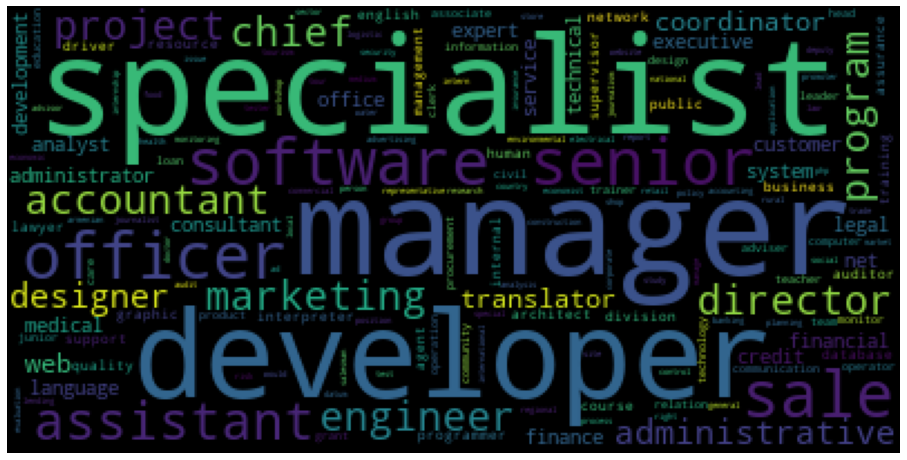

In [40]:
# Wordcloud need to draw for nature of job
wordcloud = WordCloud(stopwords=[],max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Job nature change over the period (2008 to 2011)

In [41]:
X2=Job_year[Job_year['Year_bins']=='Period2'].iloc[:,0]

In [42]:
# Selecting top 500 jobs for the wordcloud

titlecount = {}
for data in X2:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in titlecount.keys():
            titlecount[word] = 1
        else:
            titlecount[word] += 1
            
# import heapq
freq_words = heapq.nlargest(500,titlecount,key=titlecount.get)

In [43]:
%%capture
text = " ".join(freq_words)

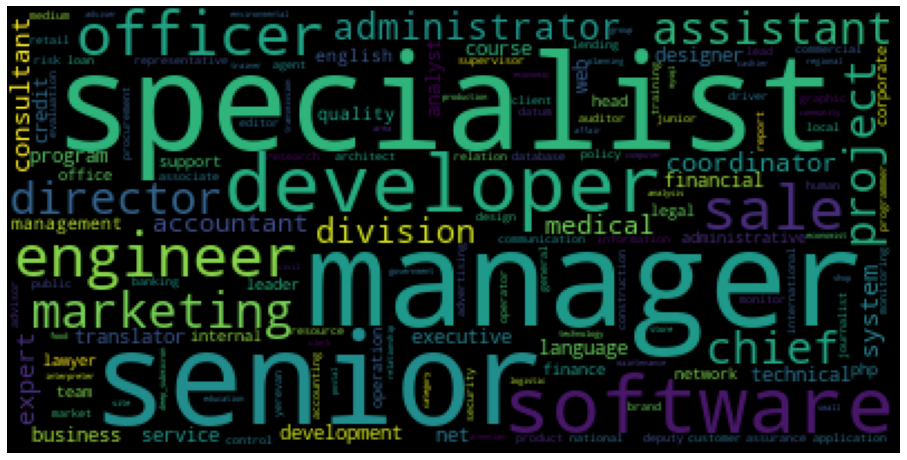

In [44]:
wordcloud = WordCloud(stopwords=[],max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()


#### Job nature change over the period (2012 to 2015)

In [45]:
X3=Job_year[Job_year['Year_bins']=='Period3'].iloc[:,0]

In [46]:
# Selecting top 500 jobs for the wordcloud

titlecount = {}
for data in X3:
    words = nltk.word_tokenize(data)
    for word in words:
        if word not in titlecount.keys():
            titlecount[word] = 1
        else:
            titlecount[word] += 1
            
# import heapq
freq_words = heapq.nlargest(500,titlecount,key=titlecount.get)

In [47]:
%%capture
text = " ".join(freq_words)

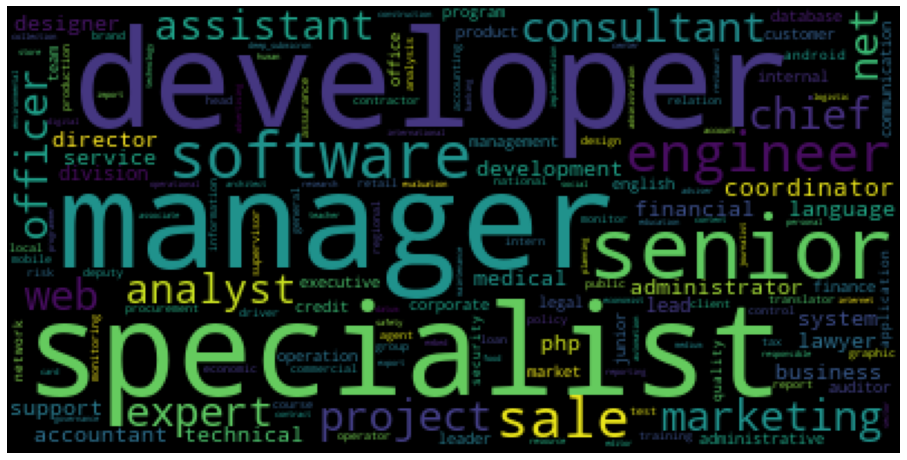

In [48]:
wordcloud = WordCloud(stopwords=[],max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### IT Job Classification

In [49]:
# Defining X
df['X1'] = df['Title'].str.cat(df['JobRequirment'], sep =" ").str.cat(df['RequiredQual'], sep =" ")
X=df['X1']

# Defining Y
di={False:0,True:1}
df['IT_y']=df['IT'].map(di)
y=df['IT_y']


In [50]:
# Creating the corpus
import re
corpus = []
for i in range(0, len(X)):
    review = re.sub(r'\W', ' ', str(X[i]))
    review = review.lower()
    review = re.sub(r'^br$', ' ', review)
    review = re.sub(r'\s+[a-z]\s+', ' ',review)
    review = re.sub(r'^[a-z]\s+', ' ', review)
    review = re.sub(r'\s+', ' ', review)
    corpus.append(review)

In [51]:
corpus[0]

'chief financial officer supervises financial management and administrative staff including assigning responsibilities reviewing employees work processes and products counseling employees giving performance evaluations and recommending disciplinary action serves as member of management team participating in both strategic and operational planning for the company directs and oversees the company financial management activities including establishing and monitoring internal controls managing cash and investments and managing the investment portfolio in collaboration with the investment team leader this includes but is not limited to evaluation of investment risk concentration risk fund deployment levels adequacy of loss and liquidity reserves assists investment team in development of proper documentation and internal systems directs and oversees the annual budgeting process including developing projections for financial planning and preparing budgets prepares external and internal financ

In [52]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# Stemming
for i in range(len(corpus)):
    words = nltk.word_tokenize(corpus[i])
    words = [stemmer.stem(word) for word in words]
    corpus[i] = ' '.join(words)  

In [53]:
corpus[0]

'chief financi offic supervis financi manag and administr staff includ assign respons review employe work process and product counsel employe give perform evalu and recommend disciplinari action serv as member of manag team particip in both strateg and oper plan for the compani direct and overse the compani financi manag activ includ establish and monitor intern control manag cash and invest and manag the invest portfolio in collabor with the invest team leader thi includ but is not limit to evalu of invest risk concentr risk fund deploy level adequaci of loss and liquid reserv assist invest team in develop of proper document and intern system direct and overse the annual budget process includ develop project for financi plan and prepar budget prepar extern and intern financi manag report such as audit financi statement tax return and report for the board of director and compani staff develop implement and maintain effici and effect account system and control to ensur complianc with na

In [54]:
# Creating the Tf-Idf model directly
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 2000, min_df = 0.05, max_df = 0.8, stop_words = stopwords.words('english'))

X = vectorizer.fit_transform(corpus).toarray()

In [55]:
X.shape

(18973, 331)

### Building Logistic Regression Model.

In [56]:
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y=train_test_split(X,
                                              y,
                                              test_size=.3,
                                              random_state=42)

In [57]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit( train_x, train_y )

LogisticRegression()

# Evaluation of Model

In [58]:
#Predicting the test cases
from sklearn import metrics
test_accuracy=metrics.accuracy_score(test_y,logreg.predict(test_x))
print('test_accuracy: ',test_accuracy)

train_accuracy=metrics.accuracy_score(train_y,logreg.predict(train_x))
print('train_accuracy: ',train_accuracy)

test_accuracy:  0.901440618411806
train_accuracy:  0.91092538212484


In [59]:
print('AUC train :',metrics.roc_auc_score(train_y,logreg.predict(train_x)))
print('AUC test :',metrics.roc_auc_score(test_y,logreg.predict(test_x)))

AUC train : 0.8130235346200951
AUC test : 0.8026893007863933


C:\Users\maclu\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Text(0.5, 15.0, 'Predicted label')

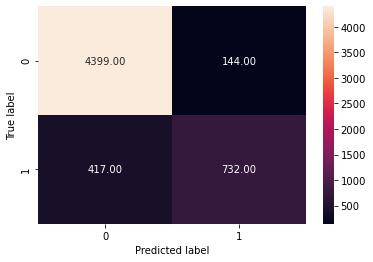

In [60]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix(test_y,
                            logreg.predict(test_x), [0,1] )
cm

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [61]:
from sklearn.metrics import classification_report
print(classification_report(test_y,logreg.predict(test_x)))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      4543
           1       0.84      0.64      0.72      1149

    accuracy                           0.90      5692
   macro avg       0.87      0.80      0.83      5692
weighted avg       0.90      0.90      0.90      5692



In [62]:
test_predicted_prob=pd.DataFrame(logreg.predict_proba(test_x))[[1]]
test_predicted_prob.columns=['prob']
actual=test_y.reset_index()
actual.drop('index',axis=1,inplace=True)

# making a DataFrame with actual and prob columns
df_test_predict = pd.concat([actual, test_predicted_prob], axis=1)
df_test_predict.columns = ['actual','prob']
df_test_predict.head()

,actual,prob
0,0,0.027010
1,0,0.055091
2,1,0.982289
3,0,0.004811
4,0,0.052375


In [64]:
test_roc_like_df = pd.DataFrame()
test_temp = df_test_predict.copy()

for cut_off in np.linspace(0,1,50):
    test_temp['predicted'] = test_temp['prob'].apply(lambda x: 0 if x < cut_off else 1)
    test_temp['tp'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==1 else 0, axis=1)
    test_temp['fp'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==1 else 0, axis=1)
    test_temp['tn'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==0 else 0, axis=1)
    test_temp['fn'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==0 else 0, axis=1)
    sensitivity = test_temp['tp'].sum() / (test_temp['tp'].sum() + test_temp['fn'].sum())
    specificity = test_temp['tn'].sum() / (test_temp['tn'].sum() + test_temp['fp'].sum())
    
    accuracy=(test_temp['tp'].sum()+test_temp['tn'].sum()) / (test_temp['tp'].sum() + test_temp['fn'].sum()+test_temp['tn'].sum() + test_temp['fp'].sum())
    
    test_roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity,accuracy]).T
    test_roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity','accuracy']
    test_roc_like_df = pd.concat([test_roc_like_df, test_roc_like_table], axis=0)

In [65]:
test_roc_like_df.head()

,cutoff,sensitivity,specificity,accuracy
0,0.000000,1.000000,0.000000,0.201862
0,0.020408,0.989556,0.449042,0.558152
0,0.040816,0.979983,0.623817,0.695713
0,0.061224,0.973020,0.694255,0.750527
0,0.081633,0.965187,0.731895,0.778988


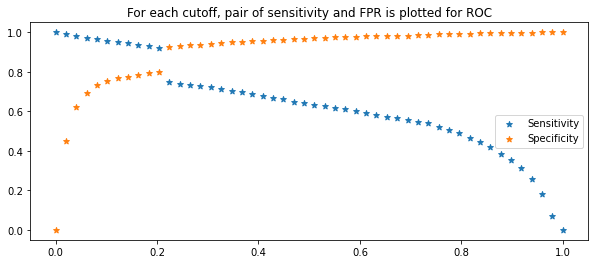

In [75]:
test_temp.sum()
plt.subplots(figsize=(10,4))
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['specificity'], marker='*', label='Specificity')
#plt.scatter(test_roc_like_df['cutoff'], 1-test_roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [76]:
#Finding ideal cut-off for checking if this remains same in OOS validation
test_roc_like_df['total'] = test_roc_like_df['sensitivity'] + test_roc_like_df['accuracy']
test_roc_like_df[test_roc_like_df['total']==test_roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.142857,0.94604,0.775039,0.809557,1.755597


<AxesSubplot:xlabel='predicted', ylabel='actual'>

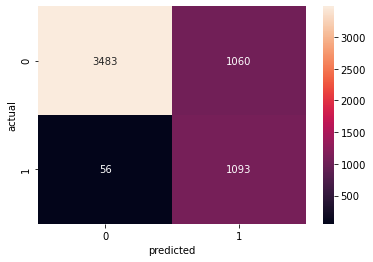

In [77]:
df_test_predict['predicted'] = df_test_predict['prob'].apply(lambda x: 1 if x > 0.122449 else 0)

import seaborn as sns
sns.heatmap(pd.crosstab(df_test_predict['actual'], df_test_predict['predicted']), annot=True, fmt='.0f')

In [78]:
accuracy=metrics.accuracy_score(df_test_predict.actual, df_test_predict.predicted)
print('Accuracy: ',round(accuracy,2))

Accuracy:  0.8


In [79]:
from sklearn.metrics import classification_report
print(classification_report(df_test_predict.actual, df_test_predict.predicted))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86      4543
           1       0.51      0.95      0.66      1149

    accuracy                           0.80      5692
   macro avg       0.75      0.86      0.76      5692
weighted avg       0.89      0.80      0.82      5692



# Building Naive Bayes Model

In [80]:
from sklearn.naive_bayes import GaussianNB

nb_clf=GaussianNB()

nb_clf.fit(train_x,train_y)

GaussianNB()

# Model Evelutation

In [81]:
#Predicting the test cases
from sklearn import metrics
test_accuracy=metrics.accuracy_score(test_y,nb_clf.predict(test_x))
print('test_accuracy: ',test_accuracy)

train_accuracy=metrics.accuracy_score(train_y,nb_clf.predict(train_x))
print('train_accuracy: ',train_accuracy)

test_accuracy:  0.808854532677442
train_accuracy:  0.8018221519463896


In [82]:
print('AUC train :',metrics.roc_auc_score(train_y,nb_clf.predict(train_x)))
print('AUC test :',metrics.roc_auc_score(test_y,nb_clf.predict(test_x)))

AUC train : 0.8365890688804225
AUC test : 0.8448192659371134


In [83]:
from sklearn.metrics import classification_report
print(classification_report(test_y,nb_clf.predict(test_x)))

              precision    recall  f1-score   support

           0       0.97      0.78      0.87      4543
           1       0.52      0.91      0.66      1149

    accuracy                           0.81      5692
   macro avg       0.74      0.84      0.76      5692
weighted avg       0.88      0.81      0.82      5692



C:\Users\maclu\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Text(0.5, 15.0, 'Predicted label')

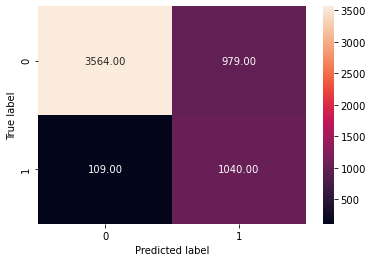

In [84]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix(test_y,
                            nb_clf.predict(test_x), [0,1] )
cm

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Apply Random forrest model

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators':[100, 200, 400, 600, 800]}

tree = GridSearchCV(RandomForestClassifier(oob_score = False,warm_start = True),param_grid,cv = 5,n_jobs = -1)
tree.fit(train_x,train_y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(warm_start=True), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 400, 600, 800]})

In [89]:
tree.best_params_

{'n_estimators': 200}

In [90]:
radm_clf=RandomForestClassifier(oob_score=True,n_estimators=200,n_jobs=-1)
radm_clf.fit(train_x,train_y)

RandomForestClassifier(n_estimators=200, n_jobs=-1, oob_score=True)

# Model Eveluation

In [91]:
#Predicting the test cases
from sklearn import metrics
test_accuracy=metrics.accuracy_score(test_y,radm_clf.predict(test_x))
print('test_accuracy: ',test_accuracy)

train_accuracy=metrics.accuracy_score(train_y,radm_clf.predict(train_x))
print('train_accuracy: ',train_accuracy)

test_accuracy:  0.9223471539002108
train_accuracy:  0.9704841502898878


In [92]:
from sklearn.metrics import classification_report
print(classification_report(test_y,radm_clf.predict(test_x)))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      4543
           1       0.92      0.67      0.78      1149

    accuracy                           0.92      5692
   macro avg       0.92      0.83      0.87      5692
weighted avg       0.92      0.92      0.92      5692



C:\Users\maclu\anaconda3\lib\site-packages\sklearn\utils\validation.py:67: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Text(0.5, 15.0, 'Predicted label')

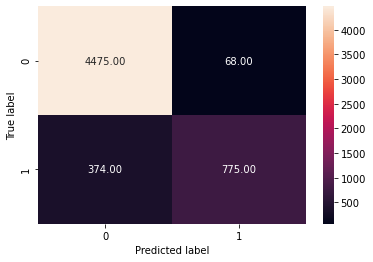

In [93]:
# Creating a confusion matrix

from sklearn import metrics

cm = metrics.confusion_matrix(test_y,
                            radm_clf.predict(test_x), [0,1] )
cm

import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline

sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["0", "1"] , yticklabels = ["0", "1"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [94]:
test_predicted_prob=pd.DataFrame(radm_clf.predict_proba(test_x))[[1]]
test_predicted_prob.columns=['prob']
actual=test_y.reset_index()
actual.drop('index',axis=1,inplace=True)

# making a DataFrame with actual and prob columns
df_test_predict = pd.concat([actual, test_predicted_prob], axis=1)
df_test_predict.columns = ['actual','prob']
df_test_predict.head()

,actual,prob
0,0,0.01
1,0,0.08
2,1,1.00
3,0,0.00
4,0,0.04


In [95]:
test_roc_like_df = pd.DataFrame()
test_temp = df_test_predict.copy()

for cut_off in np.linspace(0,1,50):
    test_temp['predicted'] = test_temp['prob'].apply(lambda x: 0 if x < cut_off else 1)
    test_temp['tp'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==1 else 0, axis=1)
    test_temp['fp'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==1 else 0, axis=1)
    test_temp['tn'] = test_temp.apply(lambda x: 1 if x['actual']==0 and x['predicted']==0 else 0, axis=1)
    test_temp['fn'] = test_temp.apply(lambda x: 1 if x['actual']==1 and x['predicted']==0 else 0, axis=1)
    sensitivity = test_temp['tp'].sum() / (test_temp['tp'].sum() + test_temp['fn'].sum())
    specificity = test_temp['tn'].sum() / (test_temp['tn'].sum() + test_temp['fp'].sum())
    
    accuracy=(test_temp['tp'].sum()+test_temp['tn'].sum()) / (test_temp['tp'].sum() + test_temp['fn'].sum()+test_temp['tn'].sum() + test_temp['fp'].sum())
    
    test_roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity,accuracy]).T
    test_roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity','accuracy']
    test_roc_like_df = pd.concat([test_roc_like_df, test_roc_like_table], axis=0)

In [96]:
test_roc_like_df.head(5)

,cutoff,sensitivity,specificity,accuracy
0,0.000000,1.000000,0.000000,0.201862
0,0.020408,0.994778,0.384548,0.507730
0,0.040816,0.992167,0.545675,0.635805
0,0.061224,0.986075,0.636584,0.707133
0,0.081633,0.981723,0.694915,0.752811


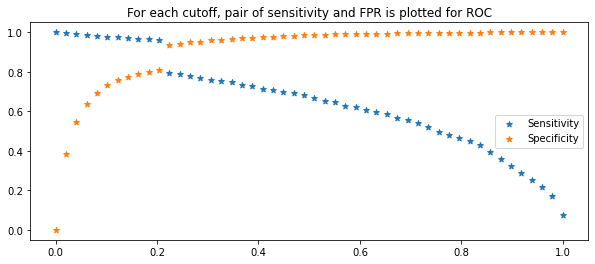

In [97]:
test_temp.sum()
plt.subplots(figsize=(10,4))
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['sensitivity'], marker='*', label='Sensitivity')
plt.scatter(test_roc_like_df['cutoff'], test_roc_like_df['specificity'], marker='*', label='Specificity')
#plt.scatter(test_roc_like_df['cutoff'], 1-test_roc_like_df['specificity'], marker='*', label='FPR')
plt.title('For each cutoff, pair of sensitivity and FPR is plotted for ROC')
plt.legend()

In [98]:
# Finding ideal cut-off for checking if this remains same in OOS validation
test_roc_like_df['total'] = test_roc_like_df['sensitivity'] + test_roc_like_df['specificity']
test_roc_like_df[test_roc_like_df['total']==test_roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,accuracy,total
0,0.204082,0.961706,0.806736,0.838018,1.768441


<AxesSubplot:xlabel='predicted', ylabel='actual'>

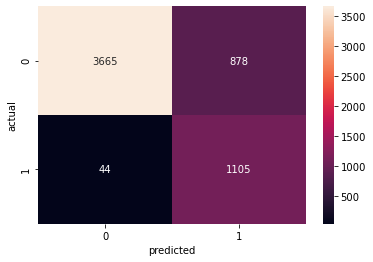

In [99]:
df_test_predict['predicted'] = df_test_predict['prob'].apply(lambda x: 1 if x > 0.204082 else 0)

import seaborn as sns
sns.heatmap(pd.crosstab(df_test_predict['actual'], df_test_predict['predicted']), annot=True, fmt='.0f')

In [100]:
accuracy=metrics.accuracy_score(df_test_predict.actual, df_test_predict.predicted)
print('Accuracy: ',round(accuracy,2))

Accuracy:  0.84


In [101]:
from sklearn.metrics import classification_report
print(classification_report(df_test_predict.actual, df_test_predict.predicted))

              precision    recall  f1-score   support

           0       0.99      0.81      0.89      4543
           1       0.56      0.96      0.71      1149

    accuracy                           0.84      5692
   macro avg       0.77      0.88      0.80      5692
weighted avg       0.90      0.84      0.85      5692



# Text Clustring

In [102]:
train_x.shape

(13281, 331)

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [104]:
title=list2
title[0:5]

['chief financial officer',
 'community connection intern pay internship',
 'country coordinator',
 'specialist',
 'software developer']

In [105]:
# Creating the Tf-Idf model directly
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 2000, min_df = 0.01, max_df = 0.9, stop_words = stopwords.words('english'))
X = vectorizer.fit_transform(title).toarray()

In [106]:
X.shape

(16523, 48)

# Cluster Error

In [107]:
cluster_range = range( 1, 21 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit(X)
    cluster_errors.append( clusters.inertia_ )

In [108]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

clusters_df[0:21]

,num_clusters,cluster_errors
0,1,13613.149119
1,2,12299.673526
2,3,11296.893946
3,4,10476.009045
4,5,10223.917752
5,6,9665.669060
6,7,9338.757192
7,8,9046.090075
8,9,8675.604299
9,10,8311.012450


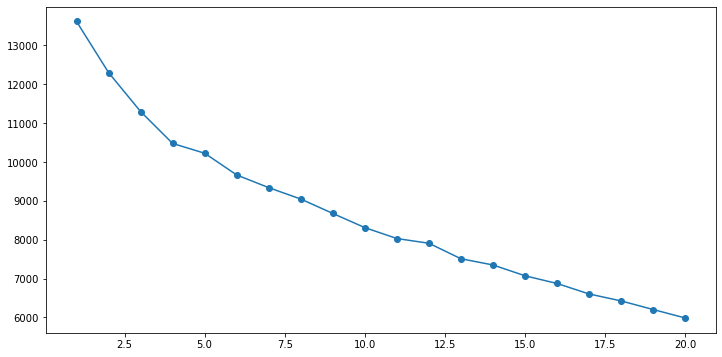

In [109]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

### Define Silhouette Coefficient

In [110]:
from sklearn import metrics

In [111]:
# calculate SC for K=3 through K=12
k_range = range(2, 21)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(X)
    scores.append(metrics.silhouette_score(X, km.labels_))

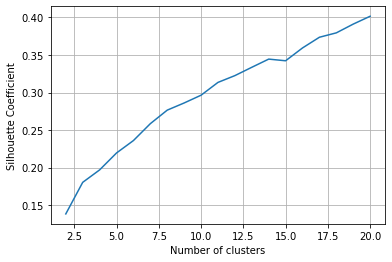

In [112]:
# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

In [113]:
true_k = 5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

KMeans(max_iter=100, n_clusters=5, n_init=1)

In [114]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

Top terms per cluster:
Cluster 0:
 manager
 sale
 engineer
 officer
 assistant
 senior
 director
 chief
 expert
 consultant
Cluster 1:
 developer
 senior
 web
 net
 php
 designer
 business
 team
 analyst
 marketing
Cluster 2:
 specialist
 marketing
 senior
 development
 sale
 management
 credit
 support
 division
 financial
Cluster 3:
 project
 coordinator
 manager
 program
 officer
 assistant
 marketing
 technical
 service
 specialist
Cluster 4:
 software
 developer
 senior
 engineer
 net
 development
 php
 quality
 team
 manager
